# 4-Node Routing Protocol Comparison Analysis

This notebook analyzes and visualizes the performance of FLOODING vs DSDV routing protocols across different mobile speeds.

**Metrics analyzed:**
- Packet Delivery Ratio (PDR)
- Network Overhead (avg transmissions per delivered packet)
- Total Network Energy Consumption

## 1. Import Required Libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Dataset

In [35]:
# Load the CSV file (skip empty rows if any)
csv_path = os.path.join("analysis reports", "4node_comparison.csv")
df = pd.read_csv(csv_path)

# Remove any completely empty rows
df = df.dropna(how='all')

# Remove rows where routing_mode is NaN (empty rows)
df = df.dropna(subset=['routing_mode'])

print("Dataset loaded successfully!")
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully!

Shape: (16, 8)

Columns: ['routing_mode', 'mobile_speed', 'total_tx_src', 'total_delivered', 'overall_pdr_pct', 'avg_delivered_per_node', 'avg_tx_per_delivered', 'total_network_energy_J']

First few rows:


,routing_mode,mobile_speed,total_tx_src,total_delivered,overall_pdr_pct,avg_delivered_per_node,avg_tx_per_delivered,total_network_energy_J
1,FLOODING,7mps,80.0,47.0,58.75,11.75,23.06,1058.33
3,FLOODING,7mps,80.0,58.0,72.50,14.50,23.02,1083.10
5,FLOODING,7mps,80.0,52.0,65.00,13.00,22.40,1063.41
7,FLOODING,7mps,80.0,55.0,68.75,13.75,22.80,1065.88
9,FLOODING,11mps,80.0,46.0,57.50,11.50,22.46,1050.12


## 3. Data Preprocessing

In [36]:
# Extract numeric speed values from mobile_speed column (e.g., "7mps" -> 7)
df['speed_numeric'] = df['mobile_speed'].str.extract(r'(\d+)').astype(int)

# Filter out rows with zero energy where needed (some runs may not have energy data)
df_with_energy = df[df['total_network_energy_J'] > 0].copy()

print("Data preprocessing complete!")
print(f"\nUnique speeds: {sorted(df['speed_numeric'].unique())}")
print(f"Routing modes: {df['routing_mode'].unique()}")
print(f"\nRows with energy data: {len(df_with_energy)} / {len(df)}")

# Group by routing mode and speed to calculate mean and std (for multiple runs)
grouped = df.groupby(['routing_mode', 'speed_numeric']).agg({
    'overall_pdr_pct': ['mean', 'std'],
    'avg_tx_per_delivered': ['mean', 'std'],
    'total_tx_src': 'mean',
    'total_delivered': 'mean'
}).reset_index()

grouped.columns = ['routing_mode', 'speed_numeric', 'pdr_mean', 'pdr_std', 
                   'overhead_mean', 'overhead_std', 'tx_src_mean', 'delivered_mean']

# Handle NaN in std (when only 1 run per group)
grouped['pdr_std'] = grouped['pdr_std'].fillna(0)
grouped['overhead_std'] = grouped['overhead_std'].fillna(0)

print("\nAggregated data (mean ± std):")
grouped

Data preprocessing complete!

Unique speeds: [np.int64(7), np.int64(11)]
Routing modes: ['FLOODING' 'DSDV']

Rows with energy data: 16 / 16

Aggregated data (mean ± std):


,routing_mode,speed_numeric,pdr_mean,pdr_std,overhead_mean,overhead_std,tx_src_mean,delivered_mean
0,DSDV,7,75.6250,2.975595,17.9475,0.490332,80.0,58.25
1,DSDV,11,74.3750,3.608439,18.2550,0.542002,80.0,59.50
2,FLOODING,7,66.2500,5.863020,22.8200,0.302435,80.0,53.00
3,FLOODING,11,60.9375,3.442232,22.4550,0.349237,80.0,48.75


## 4. Plot 1: PDR vs Speed (Grouped Bar Chart)

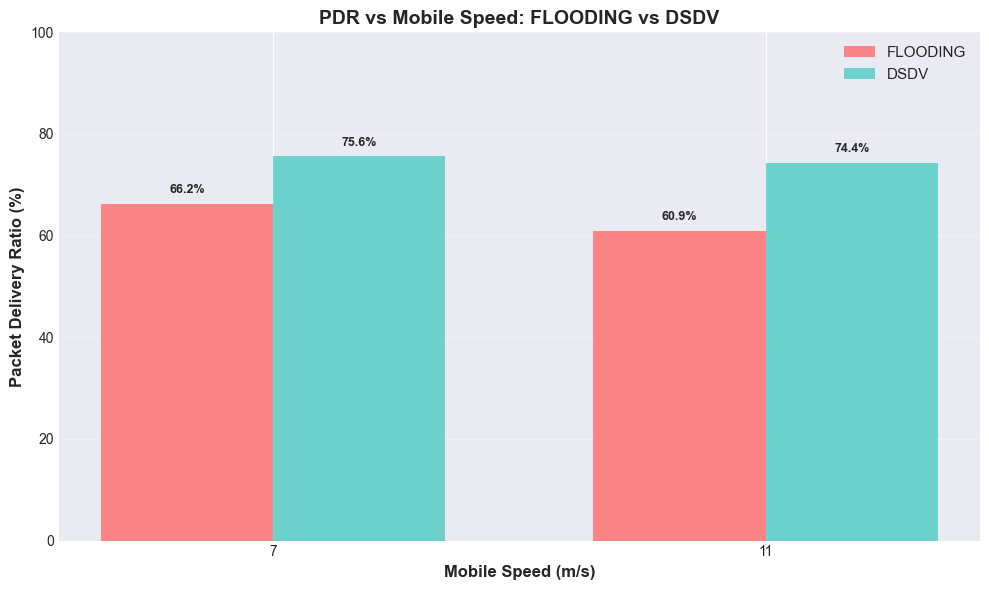

PDR vs Speed plot saved!


In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for grouped bar chart
flooding_data = grouped[grouped['routing_mode'] == 'FLOODING']
dsdv_data = grouped[grouped['routing_mode'] == 'DSDV']

speeds = sorted(grouped['speed_numeric'].unique())
x = np.arange(len(speeds))
width = 0.35

# Get values for bars
flooding_values = [flooding_data[flooding_data['speed_numeric'] == s]['pdr_mean'].values[0] if len(flooding_data[flooding_data['speed_numeric'] == s]) > 0 else 0 for s in speeds]
dsdv_values = [dsdv_data[dsdv_data['speed_numeric'] == s]['pdr_mean'].values[0] if len(dsdv_data[dsdv_data['speed_numeric'] == s]) > 0 else 0 for s in speeds]

# Create bars
bars1 = ax.bar(x - width/2, flooding_values, width, label='FLOODING', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, dsdv_values, width, label='DSDV', color='#4ECDC4', alpha=0.8)

# Add percentage labels on top of bars
for i, (bar, value) in enumerate(zip(bars1, flooding_values)):
    if value > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, (bar, value) in enumerate(zip(bars2, dsdv_values)):
    if value > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize plot
ax.set_xlabel('Mobile Speed (m/s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Packet Delivery Ratio (%)', fontsize=12, fontweight='bold')
ax.set_title('PDR vs Mobile Speed: FLOODING vs DSDV', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{s}' for s in speeds])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join('analysis reports', 'pdr_vs_speed.png'), dpi=300, bbox_inches='tight')
plt.show()

print("PDR vs Speed plot saved!")

## 5. Plot 2: Average Overhead vs Speed (Line Plot)

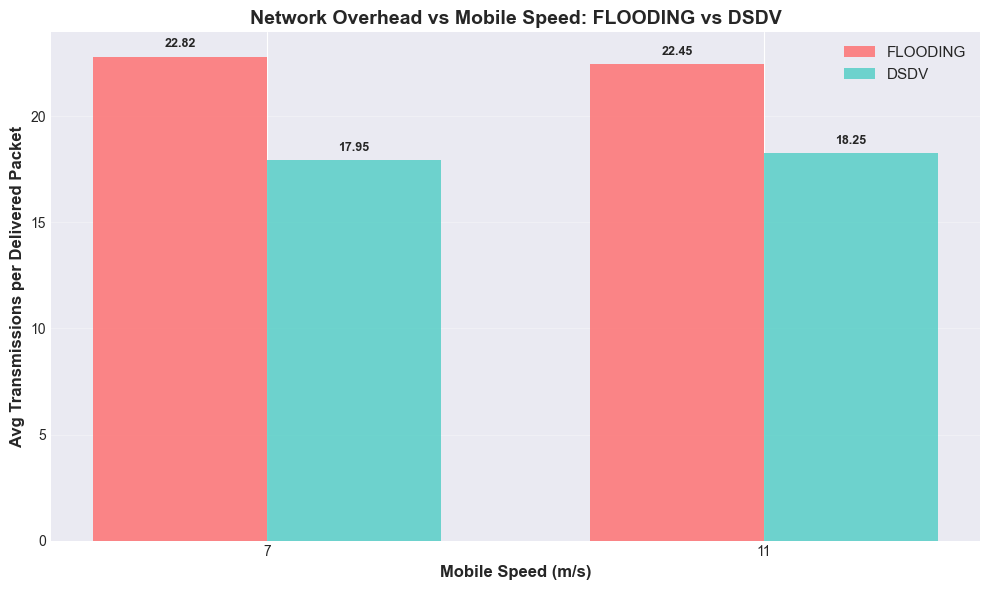

Overhead vs Speed plot saved!


In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for grouped bar chart
flooding_data = grouped[grouped['routing_mode'] == 'FLOODING']
dsdv_data = grouped[grouped['routing_mode'] == 'DSDV']

speeds = sorted(grouped['speed_numeric'].unique())
x = np.arange(len(speeds))
width = 0.35

# Get values for bars
flooding_values = [flooding_data[flooding_data['speed_numeric'] == s]['overhead_mean'].values[0] if len(flooding_data[flooding_data['speed_numeric'] == s]) > 0 else 0 for s in speeds]
dsdv_values = [dsdv_data[dsdv_data['speed_numeric'] == s]['overhead_mean'].values[0] if len(dsdv_data[dsdv_data['speed_numeric'] == s]) > 0 else 0 for s in speeds]

# Create bars
bars1 = ax.bar(x - width/2, flooding_values, width, label='FLOODING', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, dsdv_values, width, label='DSDV', color='#4ECDC4', alpha=0.8)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars1, flooding_values)):
    if value > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, (bar, value) in enumerate(zip(bars2, dsdv_values)):
    if value > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize plot
ax.set_xlabel('Mobile Speed (m/s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Avg Transmissions per Delivered Packet', fontsize=12, fontweight='bold')
ax.set_title('Network Overhead vs Mobile Speed: FLOODING vs DSDV', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{s}' for s in speeds])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join('analysis reports', 'overhead_vs_speed.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Overhead vs Speed plot saved!")

## 6. Plot 3: Energy vs Speed (Line Plot)

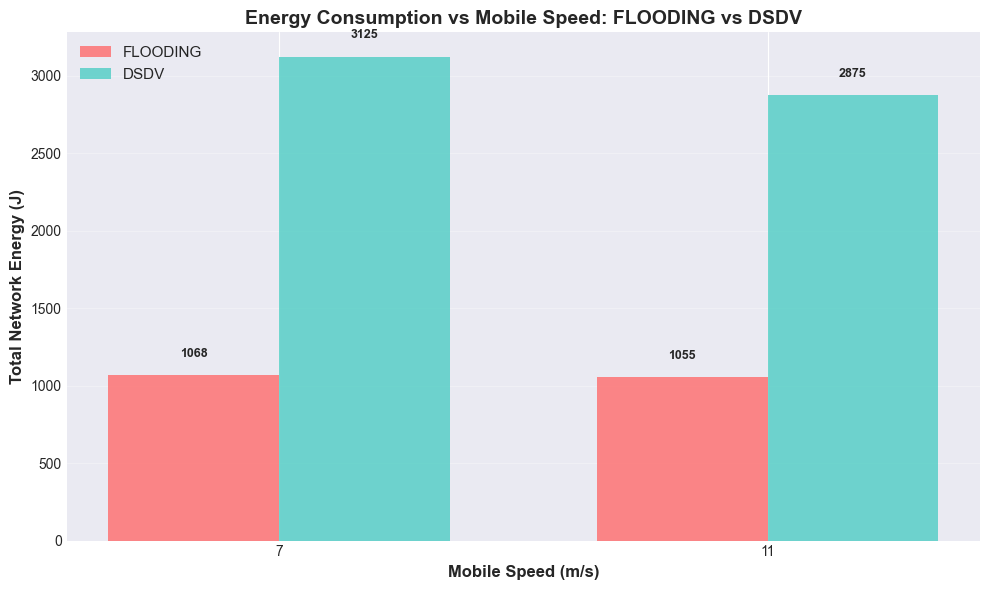

Energy vs Speed plot saved!


In [39]:
# Group energy data (excluding zeros)
energy_grouped = df_with_energy.groupby(['routing_mode', 'speed_numeric']).agg({
    'total_network_energy_J': ['mean', 'std']
}).reset_index()

energy_grouped.columns = ['routing_mode', 'speed_numeric', 'energy_mean', 'energy_std']
energy_grouped['energy_std'] = energy_grouped['energy_std'].fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for grouped bar chart
flooding_energy = energy_grouped[energy_grouped['routing_mode'] == 'FLOODING']
dsdv_energy = energy_grouped[energy_grouped['routing_mode'] == 'DSDV']

speeds = sorted(energy_grouped['speed_numeric'].unique())
x = np.arange(len(speeds))
width = 0.35

# Get values for bars
flooding_values = [flooding_energy[flooding_energy['speed_numeric'] == s]['energy_mean'].values[0] if len(flooding_energy[flooding_energy['speed_numeric'] == s]) > 0 else 0 for s in speeds]
dsdv_values = [dsdv_energy[dsdv_energy['speed_numeric'] == s]['energy_mean'].values[0] if len(dsdv_energy[dsdv_energy['speed_numeric'] == s]) > 0 else 0 for s in speeds]

# Create bars
bars1 = ax.bar(x - width/2, flooding_values, width, label='FLOODING', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, dsdv_values, width, label='DSDV', color='#4ECDC4', alpha=0.8)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars1, flooding_values)):
    if value > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{value:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, (bar, value) in enumerate(zip(bars2, dsdv_values)):
    if value > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{value:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize plot
ax.set_xlabel('Mobile Speed (m/s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Network Energy (J)', fontsize=12, fontweight='bold')
ax.set_title('Energy Consumption vs Mobile Speed: FLOODING vs DSDV', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{s}' for s in speeds])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join('analysis reports', 'energy_vs_speed.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Energy vs Speed plot saved!")

## 7. Summary Statistics

In [34]:
print("="*80)
print("SUMMARY STATISTICS BY ROUTING MODE")
print("="*80)

for mode in ['FLOODING', 'DSDV']:
    mode_df = df[df['routing_mode'] == mode]
    print(f"\n{mode}:")
    print(f"  Number of runs: {len(mode_df)}")
    print(f"  PDR: {mode_df['overall_pdr_pct'].mean():.2f}% ± {mode_df['overall_pdr_pct'].std():.2f}%")
    print(f"  Overhead: {mode_df['avg_tx_per_delivered'].mean():.2f} ± {mode_df['avg_tx_per_delivered'].std():.2f} tx/packet")
    
    energy_data = mode_df[mode_df['total_network_energy_J'] > 0]['total_network_energy_J']
    if len(energy_data) > 0:
        print(f"  Energy: {energy_data.mean():.2f} ± {energy_data.std():.2f} J")
    else:
        print(f"  Energy: No data available")

print("\n" + "="*80)
print("COMPARISON BY SPEED")
print("="*80)

comparison_table = grouped[['routing_mode', 'speed_numeric', 'pdr_mean', 'overhead_mean']].copy()
comparison_table.columns = ['Routing Mode', 'Speed (m/s)', 'PDR (%)', 'Overhead (tx/pkt)']
print("\n", comparison_table.to_string(index=False))

SUMMARY STATISTICS BY ROUTING MODE

FLOODING:
  Number of runs: 8
  PDR: 63.59% ± 5.28%
  Overhead: 22.64 ± 0.36 tx/packet
  Energy: 1061.22 ± 11.87 J

DSDV:
  Number of runs: 8
  PDR: 75.00% ± 3.13%
  Overhead: 18.10 ± 0.51 tx/packet
  Energy: 3000.00 ± 371.22 J

COMPARISON BY SPEED

 Routing Mode  Speed (m/s)  PDR (%)  Overhead (tx/pkt)
        DSDV            7  75.6250            17.9475
        DSDV           11  74.3750            18.2550
    FLOODING            7  66.2500            22.8200
    FLOODING           11  60.9375            22.4550


## Conclusion

All plots have been generated and saved to the `analysis reports` folder:
- `pdr_vs_speed.png` - Packet Delivery Ratio comparison
- `overhead_vs_speed.png` - Network overhead comparison
- `energy_vs_speed.png` - Energy consumption comparison

**Key Observations:**
- Compare PDR performance between FLOODING and DSDV routing modes
- Analyze network overhead (transmissions per delivered packet) trends
- Evaluate energy efficiency across different mobile speeds